In [1]:
import pandas as pd
import numpy as np
import warnings
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

In [135]:
import pandas as pd
#读入字段解释数据并处理成以指标为index的DataFrame
dd=pd.read_excel('illustration.XLSX',skiprows=[0]).fillna(method='ffill').drop([0])
dicts=pd.DataFrame(dd.reset_index(drop=True).values,columns=['illus2','vars','illus1','logical_illus'])
dicts.set_index('vars',drop=True)
dicts=dicts[['vars','illus1','illus2','logical_illus']].set_index('vars',drop=True)
# dicts.reset_index(inplace=True)
dicts

,illus1,illus2,logical_illus
vars,,,
y,是否逾期,被解释变量,0-未逾期 1-逾期
x_001,性别,身份信息及财产状况,0-男，1-女
x_002,年龄,身份信息及财产状况,具体年龄
x_003,是否有房,身份信息及财产状况,0-无或未知，1-有
x_004,是否有车,身份信息及财产状况,0-无或未知，1-有
x_005,是否有孩,身份信息及财产状况,0-无或未知，1-有
x_006,高消费标志,身份信息及财产状况,0-无或未知，1-有
x_007,珠宝消费标志,身份信息及财产状况,0-无或未知，1-有
x_008,婚庆消费标志,身份信息及财产状况,0-无或未知，1-有


In [149]:
# Traditional Credit Scoring Using Logistic Regression
import scorecardpy as sc
import pandas as pd
# # data prepare ------
# # load germancredit data
dat =pd.read_csv('train_data.csv')
# #dt_s=dat.copy()
# filter variable via missing rate, iv, identical value rate
dt_s = sc.var_filter(dat, y="y")
#xcol=dat.columns.to_list()[3:20]
#dt_s = sc.var_filter(dat, y="y",x=xcol)              #--------------return a DataFrame only filters out from [x]
# dt_s = sc.var_filter(dat, y="y")
dt_s = sc.var_filter(dat, y="y",return_rm_reason=True) #-------------return a dict(2 DataFrame) with keys:['dt','rm']

[INFO] filtering variables ...
Variable filtering on 7761 rows and 201 columns in 00:03:34 
71 variables are removed
[INFO] filtering variables ...
Variable filtering on 7761 rows and 201 columns in 00:03:34 
71 variables are removed


In [139]:
dt_s1=dt_s['dt']
dt_s2=dt_s['rm']

In [150]:
# dt_s2

In [316]:
##去除多重共线性
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(x, thres=10.0):
    X_m = np.matrix(x)
    VIF_list = [variance_inflation_factor(X_m, i) for i in range(X_m.shape[1])]
    maxvif=pd.DataFrame(VIF_list,index=x.columns,columns=["vif"])
    col_save=list(maxvif[maxvif.vif<=float(thres)].index)
    col_delete=list(maxvif[maxvif.vif>float(thres)].index)
    print(maxvif)
    print('delete Variables:', col_delete)
    return x[col_save]

In [320]:
ddx=pd.DataFrame()
for x in dt_s1.columns:
    ddx[x]=dt_s1[x].fillna(dt_s1[x].median())
ddy=vif(ddx,thres=10.)

              vif
x_076  284.634884
x_127    2.604582
x_142   17.802054
x_002   23.081668
x_052   14.324885
x_166         inf
x_150   23.305716
x_141    5.577162
x_175   84.941820
x_049   16.931662
x_091    1.305707
x_165  121.273609
x_192  585.288943
x_188  166.278476
x_084    1.206368
x_187    2.302179
x_050   15.483245
x_168         inf
x_197  556.785693
x_123  252.872493
x_186    8.398526
x_034    9.724420
x_167         inf
x_170  674.525280
x_181         inf
x_157  519.113391
x_025   12.964158
x_172   29.721880
x_182  261.691497
x_125  400.590996
x_184  230.102829
x_143   27.306718
x_133   30.779088
x_176   54.225781
x_048   12.930219
x_136    4.032293
x_178  113.821884
x_173    8.542954
x_134   16.291907
x_055  201.711293
x_126  233.242554
x_086   30.824751
x_065    5.488231
x_020   46.508576
x_151   62.695052
x_042   38.896841
x_014   11.774651
x_054    4.189882
x_137   18.314393
x_196  583.158642
x_195  266.147214
x_199  220.913471
x_122   90.314728
x_003    1.423877
x_131    5

In [321]:
ddy.shape

(7761, 35)

In [229]:
# fiv=sc.iv(ddy, 'y', order=True)

In [165]:
# fiv.merge(dicts.reset_index(),how='inner',right_on='vars',left_on='variable')

[INFO] creating woe binning ...
Binning on 7761 rows and 35 columns in 00:00:19


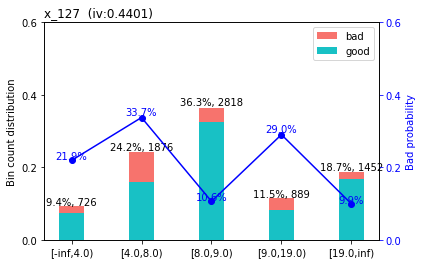

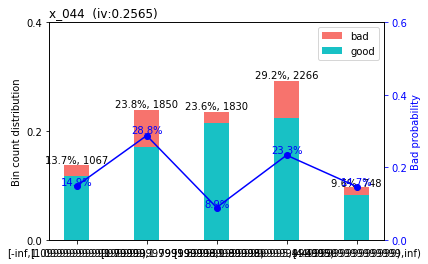

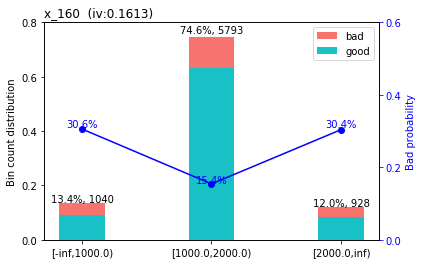

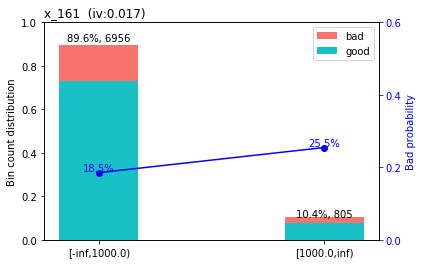

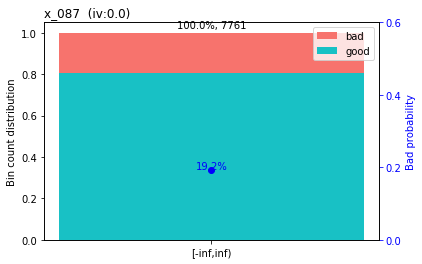

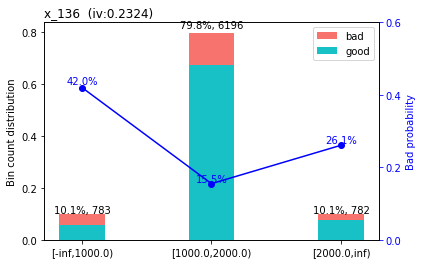

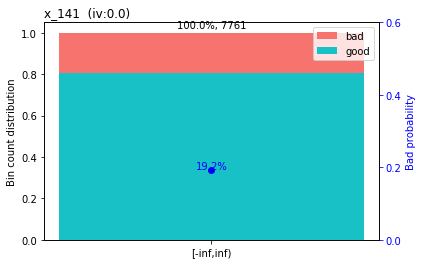

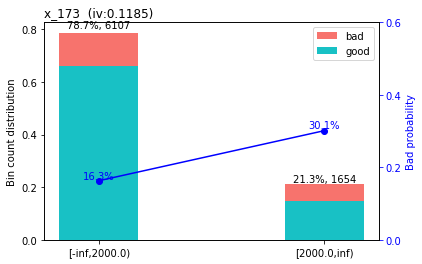

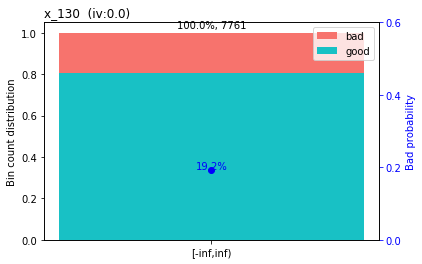

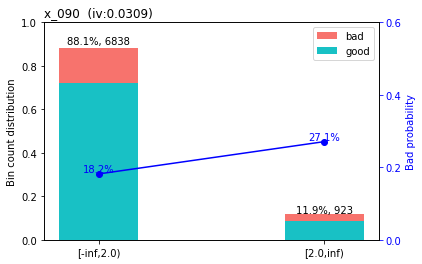

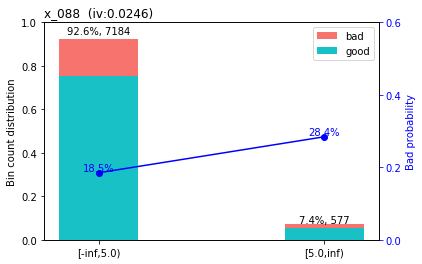

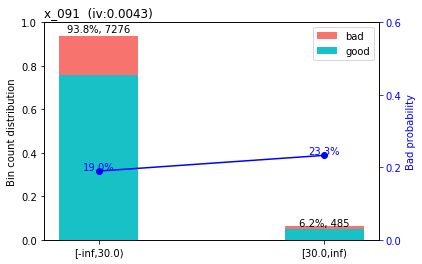

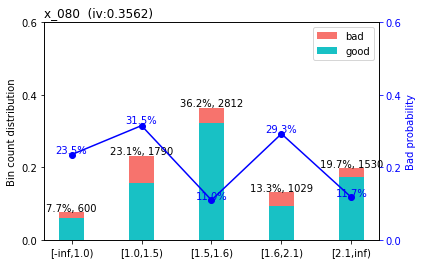

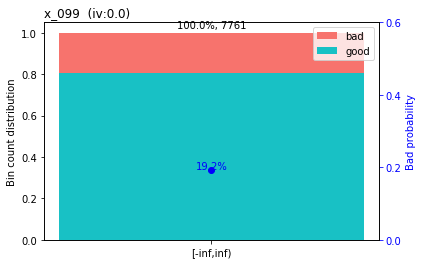

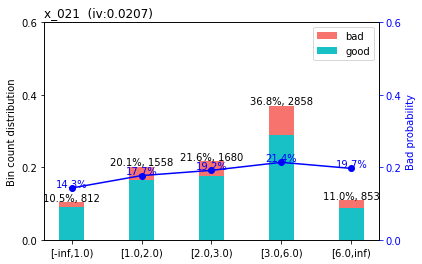

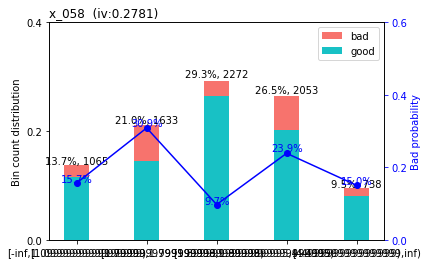

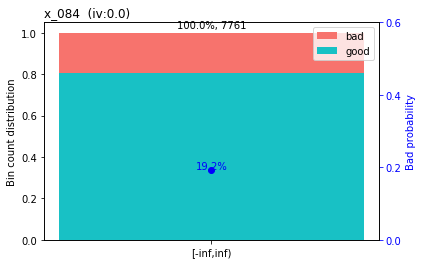

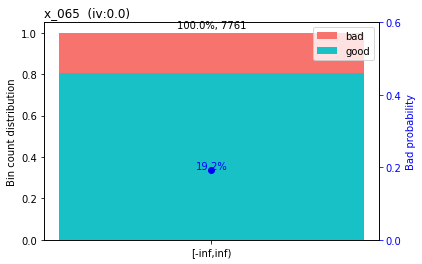

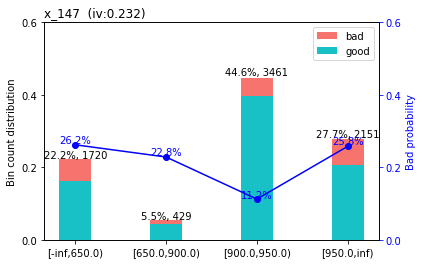

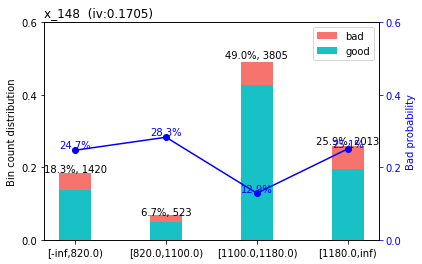

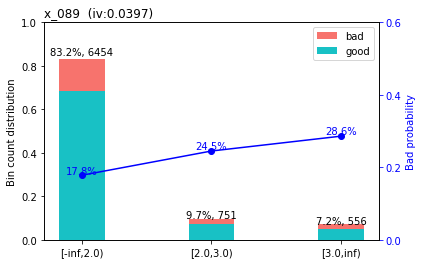

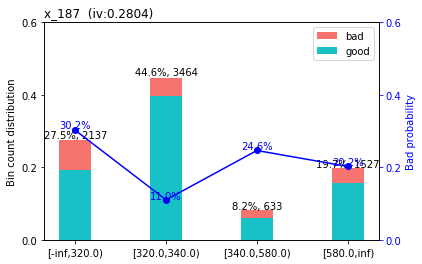

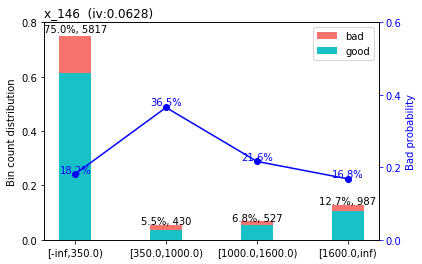

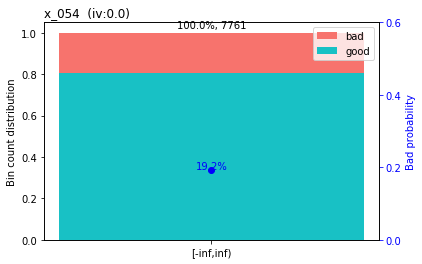

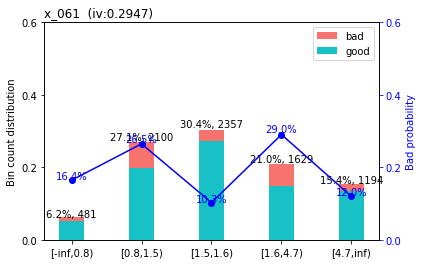

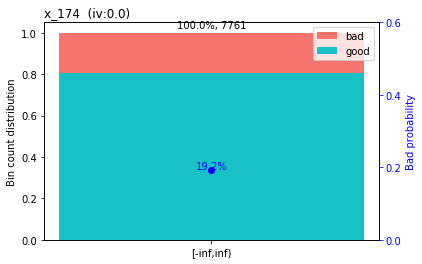

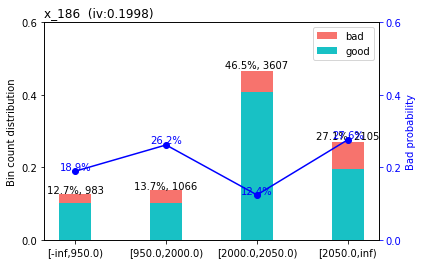

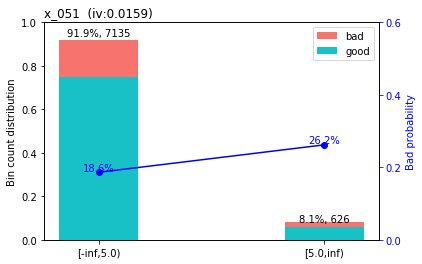

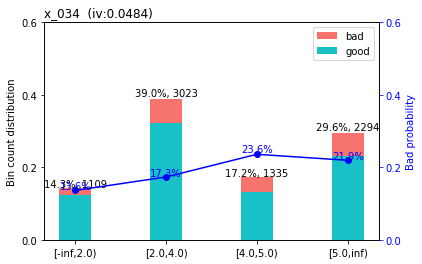

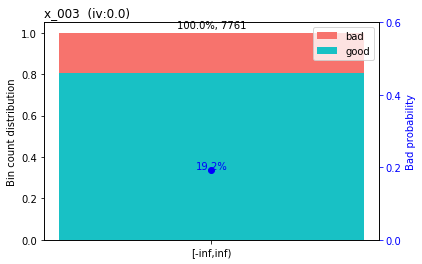

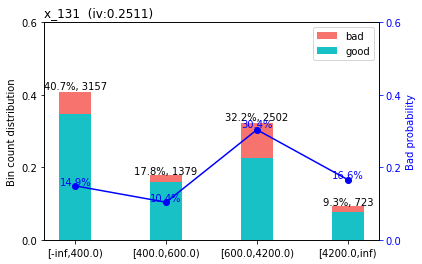

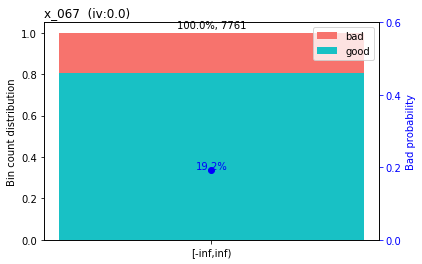

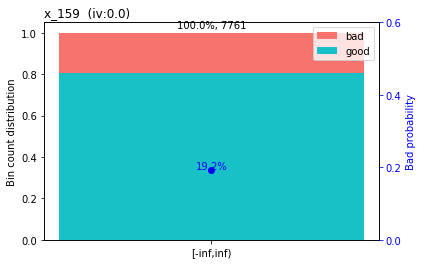

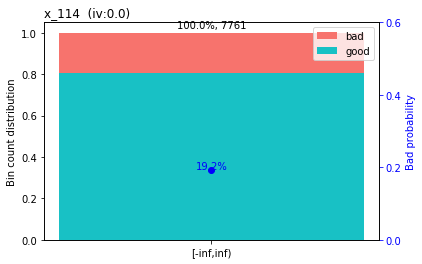

In [322]:
# special_values = {'x_018':[1]}
# bins = sc.woebin(dt_s,y="y",x=["x_018"],special_values=special_values)
bins=sc.woebin(ddy,y="y")
plots=sc.woebin_plot(bins)

In [ ]:
#print(bins['x_003'])
#print(pd.cut(dt_s['x_003'],[float('-inf'),0,float('inf')],right=False).sort_values())
#.astype(str).value_counts()

In [323]:
import numpy as np
#np.sort([bins[x].total_iv.unique()[0] for x in bins.keys()])
feature_iv=pd.DataFrame([[k,v.total_iv[0]] for k,v in bins.items()],columns=['feature','iv']).sort_values(by='iv',ascending=False)
feature_iv['illus']=[dicts.loc[x]['illus1'] for x in feature_iv['feature']]
feature_iv

,feature,iv,illus
0,x_127,0.440112,近6个月金融类消费金额均值/标准差
12,x_080,0.356208,近6个月互联网交易金额均值/标准差
24,x_061,0.294710,近6个月异地交易金额均值/标准差
21,x_187,0.280408,180天内单笔还款金额最小值
15,x_058,0.278105,近6个月异地交易笔数均值/标准差
1,x_044,0.256484,近6个月交易笔数均值/标准差
30,x_131,0.251116,最近一笔放款金额
5,x_136,0.232400,30天内单笔放款金额最小值
18,x_147,0.232009,最近一笔成功还款金额
26,x_186,0.199802,180天内单笔还款金额最大值


In [326]:
ddy_after_vif.shape

(7761, 14)

In [325]:
model_features=feature_iv[feature_iv.iv > 0.1].feature.to_list() 
ddy_after_vif=ddy[model_features+['y']]
bins=sc.woebin(ddy_after_vif,y='y')

[INFO] creating woe binning ...
Binning on 7761 rows and 14 columns in 00:00:13


In [327]:
binsx={}
for x in model_features:
    binsx[x]=bins[x]

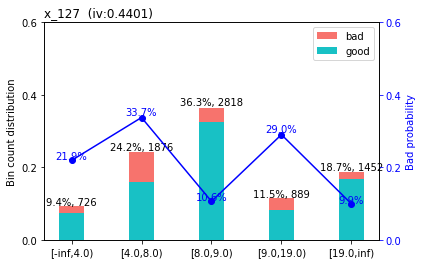

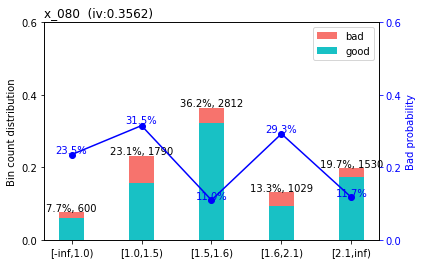

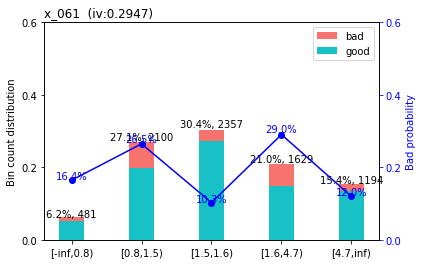

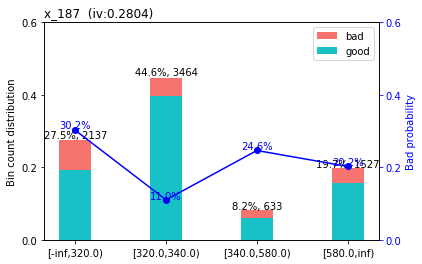

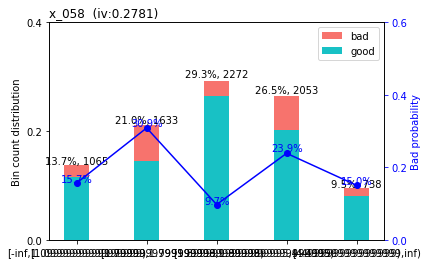

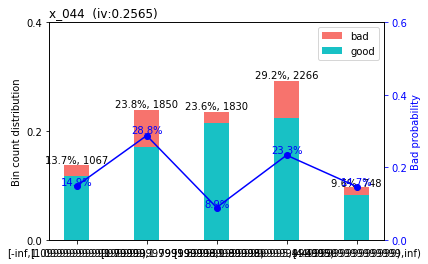

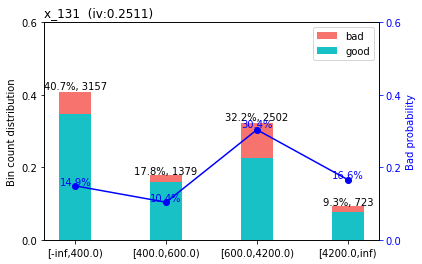

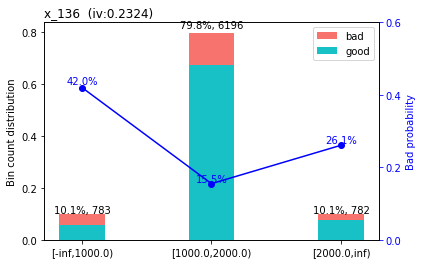

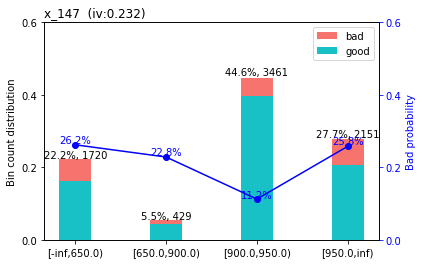

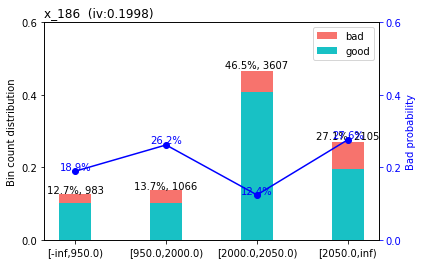

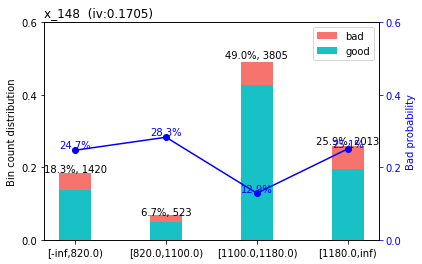

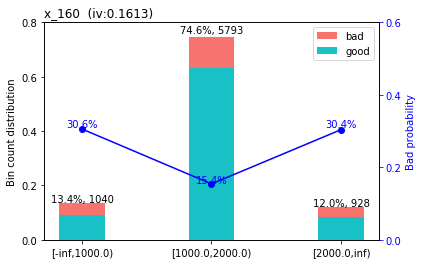

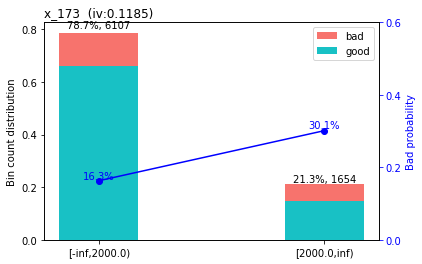

In [328]:
plots=sc.woebin_plot(binsx)

In [173]:
# biny=sc.woebin_adj(ddy_after_vif, y="y", bins=bins)

In [31]:
# biny=sc.woebin(ddy_after_vif,'y')

[INFO] creating woe binning ...
Binning on 7761 rows and 18 columns in 00:00:25


In [329]:
train, test = sc.split_df(ddy_after_vif, 'y').values()

In [ ]:
# binning adjustment
# # adjust breaks interactively
# breaks_adj = sc.woebin_adj(dt_s, "creditability", bins) 
# # or specify breaks manually
# breaks_adj = {
#     'x_003': [26, 35],
#     'other.debtors.or.guarantors': ["none", "co-applicant%,%guarantor"]
# }
# bins_adj = sc.woebin(dt_s, y="y", x="x_003", breaks_list={"x_003":[0.5]})
# sc.woebin_plot(bins_adj)
# bins=sc.woebin(dt_s, y="y", x="x_003")
# sc.woebin_plot(bins_adj)

In [330]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, binsx)
test_woe = sc.woebin_ply(test, binsx)

y_train = train_woe.loc[:,'y']
X_train = train_woe.loc[:,train_woe.columns != 'y']
y_test = test_woe.loc[:,'y']
X_test = test_woe.loc[:,train_woe.columns != 'y']

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [331]:
# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)
# lr.coef_
# lr.intercept_

# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

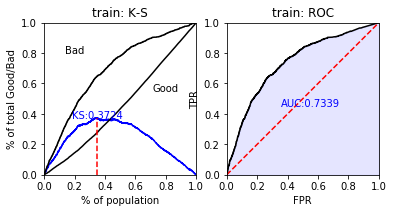

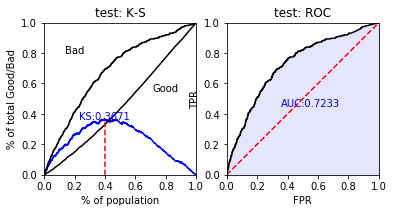

In [332]:
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [358]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
X = X_train
y = y_train
X2 = sm.add_constant(X)
# est = sm.OLS(y, X2)
# est2 = est.fit()
# print(est2.summary())
sml=sm.Logit(y,X2)
sml1=sml.fit(disp=0)
# print(sml1.summary())

In [371]:
sml1.pvalues


const        0.000000e+00
x_147_woe    5.649575e-02
x_148_woe    5.655624e-04
x_127_woe    1.953316e-10
x_187_woe    3.006627e-05
x_044_woe    2.149465e-01
x_160_woe    7.377040e-01
x_080_woe    3.366769e-03
x_131_woe    1.113648e-05
x_061_woe    4.981048e-01
x_136_woe    3.025508e-14
x_058_woe    3.166637e-01
x_186_woe    6.692764e-02
x_173_woe    6.682100e-01
dtype: float64

In [390]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.02,
                       threshold_out = 0.05,
                       verbose = True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
 
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
#             model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        print('new_pval',new_pval)
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
 
        # backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        # use all coefs except intercept
        print(included)
        #pvalues = model.pvalues.iloc[:]
        pvalues=model.pvalues
        #print('pvalues',pvalues)
        worst_pval = pvalues.max() # null if pvalues is empty
        #print('pvalues--------------',pvalues,worst_pval,changed)
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [392]:
result = stepwise_selection(X_train, y_train,
                            threshold_in=0.05,
                            threshold_out = 0.1,)
 
# print('resulting features:')
# print(result)

new_pval x_061_woe    9.032748e-49
x_136_woe    2.194760e-48
x_127_woe    6.403638e-76
x_058_woe    2.851294e-48
x_160_woe    9.406599e-32
x_131_woe    3.524686e-48
x_080_woe    1.737050e-61
x_148_woe    5.867232e-35
x_187_woe    1.979076e-53
x_147_woe    5.970724e-41
x_186_woe    2.911232e-36
x_044_woe    1.953036e-40
x_173_woe    1.872486e-22
dtype: float64
Add  x_127_woe                      with p-value 6.40364e-76
['x_127_woe']
new_pval x_061_woe    1.505013e-07
x_136_woe    1.880529e-22
x_058_woe    4.007717e-11
x_160_woe    8.006074e-10
x_131_woe    4.346012e-17
x_080_woe    1.038850e-09
x_148_woe    1.992549e-15
x_187_woe    1.063915e-21
x_147_woe    5.948059e-14
x_186_woe    3.542861e-10
x_044_woe    8.862278e-10
x_173_woe    1.915748e-06
dtype: float64
Add  x_136_woe                      with p-value 1.88053e-22
['x_127_woe', 'x_136_woe']
new_pval x_061_woe    1.105163e-05
x_058_woe    1.167002e-08
x_160_woe    1.106415e-05
x_131_woe    6.451896e-15
x_080_woe    1.332755e-07


In [336]:
X = X_train[result]
y = y_train
X2 = sm.add_constant(X)
# est = sm.OLS(y, X2)
# est2 = est.fit()
# print(est2.summary())
sml=sm.Logit(y,X2)
sml1=sml.fit()
print(sml1.summary())

Optimization terminated successfully.
         Current function value: 0.435374
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5433
Model:                          Logit   Df Residuals:                     5424
Method:                           MLE   Df Model:                            8
Date:                Mon, 04 May 2020   Pseudo R-squ.:                  0.1108
Time:                        09:45:08   Log-Likelihood:                -2365.4
converged:                       True   LL-Null:                       -2660.0
Covariance Type:            nonrobust   LLR p-value:                4.783e-122
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4497      0.038    -38.325      0.000      -1.524      -1.376
x_127_woe      0.4781      0.

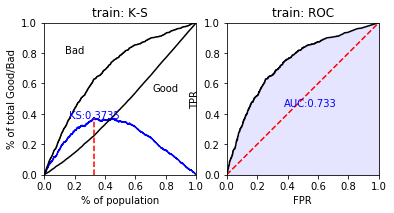

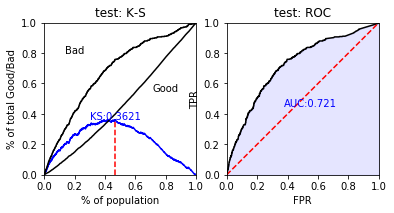

In [337]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train[result], y_train)
# lr.coef_
# lr.intercept_

# predicted proability
train_pred = lr.predict_proba(X_train[result])[:,1]
test_pred = lr.predict_proba(X_test[result])[:,1]
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [338]:
lr.coef_

array([[ 0.47739831,  0.56003456,  0.58788674,  0.37387345,  0.24775849,
         0.3432079 , -0.4459648 ,  0.2515875 ]])

In [372]:
pd.DataFrame([(x,feature_iv.set_index('feature').illus.loc[x],
               feature_iv.set_index('feature').iv.loc[x],
               sml1.params.loc[x+'_woe'],
               sml1.pvalues.loc[x+'_woe']) for x in model_features],
               columns=['vars','illus','iv','cof','P_val'])

,vars,illus,iv,cof,P_val
0,x_127,近6个月金融类消费金额均值/标准差,0.440112,0.466692,1.953316e-10
1,x_080,近6个月互联网交易金额均值/标准差,0.356208,0.236110,3.366769e-03
2,x_061,近6个月异地交易金额均值/标准差,0.294710,0.062175,4.981048e-01
3,x_187,180天内单笔还款金额最小值,0.280408,0.645261,3.006627e-05
4,x_058,近6个月异地交易笔数均值/标准差,0.278105,0.125515,3.166637e-01
5,x_044,近6个月交易笔数均值/标准差,0.256484,0.153624,2.149465e-01
6,x_131,最近一笔放款金额,0.251116,0.382608,1.113648e-05
7,x_136,30天内单笔放款金额最小值,0.232400,0.561090,3.025508e-14
8,x_147,最近一笔成功还款金额,0.232009,-0.366276,5.649575e-02
9,x_186,180天内单笔还款金额最大值,0.199802,-0.275374,6.692764e-02


In [ ]:
# score ------
card = sc.scorecard(bins, lr, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

In [ ]:
# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)